In [2]:
import numpy as np
from matplotlib import pyplot
import matplotlib.colors as mcolors
from IPython.display import display, Math, Markdown
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [3]:
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

In [4]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, bathymetry: np.ndarray, h_initial: np.ndarray, uh_initial: np.ndarray | None = None,
                 vh_initial: np.ndarray | None = None, options: Options = None):

        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y = 0, 1
        grid = h_initial.shape
        stepper = Stepper(options=options, n_threads=1, grid=grid)

        if uh_initial is None:
            uh_initial = np.zeros(grid)
        if vh_initial is None:
            vh_initial = np.zeros(grid)

        assert uh_initial.shape == grid
        assert vh_initial.shape == grid

        kwargs = {
            "boundary_conditions": [boundary_conditions.Constant(value=0)] * len(grid),
            "halo": options.n_halo,
        }

        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
            "vh": ScalarField(vh_initial, **kwargs),
        }

        self.advector = VectorField((np.zeros((grid[X] + 1, grid[Y])), np.zeros((grid[X], grid[Y] + 1))), **kwargs)
        self.solvers = {k: Solver(stepper, v, self.advector) for k, v in advectees.items()}
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """zwraca pole advectee o nazwie `key` w obecnym stanie"""
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """aplikuje połowę źródła g*h*∂(h-b)/∂x lub ∂(h-b)/∂y do pędu"""
        self[key][:] -= 0.5 * g_times_dt_over_dxy * self["h"] * np.gradient(self["h"] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """Wyznacza liczby Couranta z pędów i wysokości kolumny."""
        velocity = np.where(mask, np.nan, 0.0)
        momentum = self[key]
        np.divide(momentum, self["h"], where=mask, out=velocity)

        all_ = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = (velocity[((all_but_last, all_), (all_, all_but_last))[axis]] + np.diff(velocity, axis=axis) / 2)

        courant_number = self.advector.get_component(axis)[((all_but_first_and_last, all_), (all_, all_but_first_and_last))[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]

        assert np.amax(np.abs(courant_number)) <= 1.0

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float = 1e-7):
        """
        Integruje `nt` kroków czasowych, zapisuje stan co `outfreq` kroków
        i zwraca słownik list: { "h": [...], "uh": [...], "vh": [...] }.
        """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self["h"] > eps

                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)

                self.solvers["h"].advance(n_steps=1)

                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])

            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())

        return output

In [5]:
class BathymetryModel:

    KINDS = {"gentle_slope": {"title": "Gentle slope - reference type",
                              "mode": "gentle"},
             "steep_slope": {"title": "Gaussian bump before slope",
                             "mode": "bump",   
                             "xi_center": 0.3,
                             "xi_width": 0.08,
                             "height": 0.5},
             "two_step_slope": {"title": "Two-step slope",
                                "mode": "two_step",
                                "xi1_center": 0.30,
                                "xi2_center": 0.90,
                                "sharpness1": 0.06,
                                "sharpness2": 0.04},
             "pit_before_slope": {"title": "Gaussian pit before slope",
                                 "mode": "pit",
                                 "xi_center": 0.3,
                                 "xi_width": 0.08,
                                 "depth": 0.5},
            }

    def __init__(self, grid=(1000, 250), h_deep=0.8, h_mid=0.5, h_shallow=0.1, bathymetry_min=0.01, x_min=-0.5, x_max=1.0,
                 x_flat_bottom_end=0.3, x_shallow_flat_start=0.8):
        self.grid = grid
        self.h_deep = h_deep
        self.h_mid = h_mid
        self.h_shallow = h_shallow
        self.bathymetry_min = bathymetry_min

        self.x_min = x_min
        self.x_max = x_max

        self.x_flat_bottom_end = x_flat_bottom_end
        self.x_shallow_flat_start = x_shallow_flat_start
        self.x_shore_center = 0.5 * (x_shallow_flat_start + x_max)

        self.X, self.Y = self._make_xy(grid, x_min=x_min, x_max=x_max)

        self.Lx_phys = Q_(1.5, "km")    
        self.Ly_phys = Q_(0.75, "km")    
        self.depth_scale = Q_(50.0, "m") 

    @staticmethod
    def _make_xy(grid, x_min=0.0, x_max=1.0):
        nx, ny = grid
        x = np.linspace(x_min, x_max, nx)
        y = np.linspace(0.0, 1.0, ny)
        return np.meshgrid(x, y, indexing="ij")

    @staticmethod
    def smoothstep01(xi):
        return 3.0 * xi**2 - 2.0 * xi**3

    @staticmethod
    def smooth_step(xi, center, sharp):
        return 0.5 * (1.0 + np.tanh((xi - center) / sharp))

    @classmethod
    def kind_title(cls, slope_kind):
        return cls.KINDS[slope_kind]["title"]

    def generate_base_bathymetry(self):
        grid_x = self.X
        bathymetry = np.empty_like(grid_x)

        mask_bottom = grid_x <= self.x_flat_bottom_end
        bathymetry[mask_bottom] = self.h_deep

        mask_shallow = grid_x >= self.x_shallow_flat_start
        bathymetry[mask_shallow] = self.h_shallow

        mask_slope = (~mask_bottom) & (~mask_shallow)

        position_on_slope = np.zeros_like(grid_x)
        position_on_slope[mask_slope] = ((grid_x[mask_slope] - self.x_flat_bottom_end) / (self.x_shallow_flat_start - self.x_flat_bottom_end)) 

        w_slope = np.zeros_like(position_on_slope)
        w_slope[mask_slope] = self.smoothstep01(position_on_slope[mask_slope])

        bathymetry[mask_slope] = self.h_deep - (self.h_deep - self.h_shallow) * w_slope[mask_slope]

        return np.maximum(bathymetry, self.bathymetry_min)

    def generate(self, kind: str):
        params = self.KINDS[kind]
        mode = params["mode"]

        if mode == "gentle":
            return self.generate_base_bathymetry()

        grid_x = self.X
        bathymetry = self.generate_base_bathymetry()

        mask_bottom = grid_x <= self.x_flat_bottom_end
        mask_shallow = grid_x >= self.x_shallow_flat_start
        mask_slope = (~mask_bottom) & (~mask_shallow)

        position_on_slope = np.zeros_like(grid_x)
        position_on_slope[mask_slope] = ((grid_x[mask_slope] - self.x_flat_bottom_end) / (self.x_shallow_flat_start - self.x_flat_bottom_end))  

        if mode == "bump":
            xi_center = params["xi_center"]
            xi_width = params["xi_width"]
            height = params["height"]  

            slope_base = self.smoothstep01(position_on_slope)
            bathymetry[mask_slope] = (self.h_deep - (self.h_deep - self.h_shallow) * slope_base[mask_slope])

            bump = np.zeros_like(grid_x)
            bump[mask_slope] = height * np.exp(-((position_on_slope[mask_slope] - xi_center) ** 2) / (2.0 * xi_width ** 2))
            bathymetry[mask_slope] -= bump[mask_slope]

        elif mode == "two_step":
            xi1_center = params["xi1_center"]
            xi2_center = params["xi2_center"]
            sharpness1 = params["sharpness1"]
            sharpness2 = params["sharpness2"]

            slope1 = np.zeros_like(position_on_slope)
            slope2 = np.zeros_like(position_on_slope)
            slope1[mask_slope] = self.smooth_step(position_on_slope[mask_slope], xi1_center, sharpness1)
            slope2[mask_slope] = self.smooth_step(position_on_slope[mask_slope], xi2_center, sharpness2)

            deep_section = 1.0 - slope1
            shallow_section = slope2
            mid_section = slope1 * (1.0 - slope2)

            bathymetry[mask_slope] = (
                    self.h_deep * deep_section[mask_slope]
                    + self.h_mid * mid_section[mask_slope]
                    + self.h_shallow * shallow_section[mask_slope]
            )

        elif mode == "pit":
            xi_center = params["xi_center"]
            xi_width = params["xi_width"]
            depth = params["depth"]

            slope_base = self.smoothstep01(position_on_slope)
            bathymetry[mask_slope] = (self.h_deep - (self.h_deep - self.h_shallow) * slope_base[mask_slope])

            pit = np.zeros_like(grid_x)
            pit[mask_slope] = depth * np.exp(-((position_on_slope[mask_slope] - xi_center) ** 2) / (2.0 * xi_width ** 2))
            bathymetry[mask_slope] += pit[mask_slope]

        else:
            raise ValueError(f"Unknown bathymetry type: {kind}")

        bathymetry[grid_x <= self.x_flat_bottom_end] = self.h_deep
        bathymetry[grid_x >= self.x_shallow_flat_start] = self.h_shallow

        return np.maximum(bathymetry, self.bathymetry_min)

    def get_bathymetry_range_dimless(self, kinds):
        bathymetry_all = np.array([self.generate(k) for k in kinds])
        return float(bathymetry_all.min()), float(bathymetry_all.max())

In [6]:
class ShallowWaterExperiment:
    def __init__(self, bathymetry_model: BathymetryModel, g: float = 9.81, sim_time: int = 250,
                 outfreq: int = 5, dt_over_dxy=(0.25, 0.25), kinds=None):
        self.bathymetry_model = bathymetry_model
        self.g = g
        self.sim_time = sim_time
        self.outfreq = outfreq
        self.dt_over_dxy = dt_over_dxy
        self.kinds = kinds or list(BathymetryModel.KINDS.keys())

        self.results = {}
        self.arrival_frames = {}
        self.arrival_steps = {}
        self.max_zeta_series = {}

        grid_x = self.bathymetry_model.X[:, 0]
        self.mask_visible = (grid_x >= 0.0) & (grid_x <= 1.0)
        self.x_frame = grid_x[self.mask_visible]
        self.x_frame_idx = np.where(self.mask_visible)[0]

        self.Lx_phys = Q_(self.bathymetry_model.Lx_phys, "m")
        self.Ly_phys = Q_(self.bathymetry_model.Ly_phys, "m")
        self.depth_scale = self.bathymetry_model.depth_scale

        h_deep_dimless = self.bathymetry_model.h_deep
        h_deep_phys = h_deep_dimless * self.depth_scale

        self.g_phys = Q_(self.g, "m/s^2")
        self.c_phys_ref = (self.g_phys * h_deep_phys) ** 0.5
        self.c_dimless_ref = np.sqrt(self.g * h_deep_dimless)

        nx, _ = self.bathymetry_model.grid
        self.dx_dimless = (self.bathymetry_model.x_max - self.bathymetry_model.x_min) / (nx - 1)
        self.dt_dimless = self.dt_over_dxy[0] * self.dx_dimless

        self.T_scale = self.Lx_phys * self.c_dimless_ref / self.c_phys_ref
        self.dt_phys = self.dt_dimless * self.T_scale

        self.vel_scale_kmh = (self.Lx_phys.to("km") / self.T_scale.to("hour")).magnitude

        self.speed_max_kmh = None

    def generate_initial_condition(self, bathymetry: np.ndarray, amplitude_wave: float = 0.2, x0_wave: float = 0.2,
                                   sigma_wave: float = 0.05, u_sigma: float = 3.0):
        X = self.bathymetry_model.X
        grid_x = X[:, 0]
        _, ny = bathymetry.shape

        wave_x = amplitude_wave * np.exp(-((grid_x - x0_wave) / sigma_wave) ** 2)
        wave_xy = wave_x[:, None] * np.ones((1, ny))

        h0 = bathymetry + wave_xy

        H0 = self.bathymetry_model.h_deep
        c0 = np.sqrt(self.g * H0)

        u_x = np.zeros_like(grid_x)
        mask_bump = np.abs(grid_x - x0_wave) <= u_sigma * sigma_wave
        u_x[mask_bump] = (c0 / H0) * wave_x[mask_bump]

        u_xy = u_x[:, None] * np.ones((1, ny))

        uh0 = h0 * u_xy
        vh0 = np.zeros_like(h0)

        return h0, uh0, vh0

    def run(self):
        grid_x = self.bathymetry_model.X[:, 0]
        middle_of_shallows_arg = np.argmin(np.abs(grid_x - self.bathymetry_model.x_shore_center))

        for kind in self.kinds:
            bathymetry = self.bathymetry_model.generate(kind)
            h0, uh0, vh0 = self.generate_initial_condition(bathymetry)

            integrator = ShallowWaterEquationsIntegrator(h_initial=h0, uh_initial=uh0, vh_initial=vh0, bathymetry=bathymetry)

            result = integrator(nt=self.sim_time, g=self.g, dt_over_dxy=self.dt_over_dxy, outfreq=self.outfreq)

            wave_heights = []
            for h_frame in result["h"]:
                middle_of_shallows_zeta = (h_frame - bathymetry)[middle_of_shallows_arg, :]
                wave_heights.append(np.max(middle_of_shallows_zeta))

            wave_heights = np.array(wave_heights)
            zeta_max = np.max(wave_heights)

            self.results[kind] = {"bathymetry": bathymetry,
                                  "result": result,
                                  "wave_heights": wave_heights,
                                  "zeta_max": zeta_max,
                                }

        self._compute_velocity_max()

    def _compute_velocity_from_frames(self, h_frame, uh_frame, vh_frame):
        eps = 1e-7
        u = np.zeros_like(h_frame)
        v = np.zeros_like(h_frame)
        mask_h = h_frame > eps
        u[mask_h] = uh_frame[mask_h] / h_frame[mask_h]
        v[mask_h] = vh_frame[mask_h] / h_frame[mask_h]

        mask = self.mask_visible
        u_vis = u[mask, :] * self.vel_scale_kmh
        v_vis = v[mask, :] * self.vel_scale_kmh
        speed_vis = np.sqrt(u_vis**2 + v_vis**2)

        return u_vis, v_vis, speed_vis

    def _compute_velocity_max(self):
        speed_max = 0.0

        for kind in self.kinds:
            data = self.results[kind]
            result = data["result"]

            h_list = result["h"]
            uh_list = result["uh"]
            vh_list = result["vh"]

            for h_frame, uh_frame, vh_frame in zip(h_list, uh_list, vh_list):
                _, _, speed_vis = self._compute_velocity_from_frames(h_frame, uh_frame, vh_frame)
                smax = float(speed_vis.max())
                if smax > speed_max:
                    speed_max = smax
                    
        self.speed_max_kmh = speed_max

    def get_velocity_frame(self, kind: str, frame: int):
        data = self.results[kind]
        result = data["result"]

        max_frame = self.arrival_frames[kind]
        frame_eff = min(frame, max_frame)

        h_frame = result["h"][frame_eff]
        uh_frame = result["uh"][frame_eff]
        vh_frame = result["vh"][frame_eff]

        u_vis, v_vis, speed_vis = self._compute_velocity_from_frames(h_frame, uh_frame, vh_frame)

        return {"frame_eff": frame_eff,
                "u_vis": u_vis,
                "v_vis": v_vis,
                "speed_vis": speed_vis}

    def compute_arrival_to_shore_times(self, threshold_frac: float = 0.05):
        for kind in self.kinds:
            wave_heights = self.results[kind]["wave_heights"]
            max_zeta = np.max(wave_heights)

            threshold = threshold_frac * max_zeta
            idx = None
            for i, zeta in enumerate(wave_heights):
                if zeta > threshold:
                    idx = i
                    break
            if idx is None:
                idx = len(wave_heights) - 1

            self.arrival_frames[kind] = idx
            self.arrival_steps[kind] = idx * self.outfreq

    def compute_max_zeta_in_time(self):
        nx, ny = self.bathymetry_model.grid
        mid_y = ny // 2

        for kind in self.kinds:
            data = self.results[kind]
            bathymetry = data["bathymetry"]
            h_list = data["result"]["h"]

            last_frame = self.arrival_frames[kind]
            n_frames = last_frame + 1

            z_max_list = []
            for frame in range(n_frames):
                zeta = h_list[frame] - bathymetry
                z_line = zeta[:, mid_y]
                z_max_list.append(np.max(z_line))

            z_max = np.array(z_max_list)
            t_steps = np.arange(n_frames) * self.outfreq

            dt_phys_s = self.dt_phys.to("s").magnitude
            t_phys = t_steps * dt_phys_s

            self.max_zeta_series[kind] = {"t_steps": t_steps,
                                          "t_phys": t_phys,
                                          "z_max": z_max}

    def print_arrival_summary(self):
        dt_phys_s = self.dt_phys.to("s").magnitude
        for kind in self.kinds:
            frame = self.arrival_frames.get(kind, None)
            steps = self.arrival_steps.get(kind, None)
 
            t_phys = steps * dt_phys_s
            title = BathymetryModel.kind_title(kind)

            display(Math(
                fr'\text{{{title}}}: '
                fr'\text{{frame}} = {frame},\; '
                fr't/\Delta t \approx {steps},\; '
                fr't \approx {t_phys:.1f}\,\text{{s}}'
            ))

In [51]:
class ShallowWaterPlotter:

    def __init__(self, bathymetry_model: BathymetryModel, experiment: ShallowWaterExperiment | None = None):
        self.bathymetry_model = bathymetry_model
        self.experiment = experiment

        self.kinds = list(BathymetryModel.KINDS.keys()) if experiment is None else experiment.kinds

        self.Lx_phys = self.bathymetry_model.Lx_phys
        self.Ly_phys = self.bathymetry_model.Ly_phys
        self.depth_scale = self.bathymetry_model.depth_scale

        if experiment is not None:
            self.mask_visible = experiment.mask_visible
            self.x_visible = experiment.x_frame
        else:
            grid_x = self.bathymetry_model.X[:, 0]
            self.mask_visible = (grid_x >= 0.0) & (grid_x <= 1.0)
            self.x_visible = grid_x[self.mask_visible]


    def plot_bathymetry_maps(self):
        fig, axes = pyplot.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
        axes = axes.ravel()

        Lx_km = self.Lx_phys.to("km").magnitude
        Ly_km = self.Ly_phys.to("km").magnitude
        X_phys = self.bathymetry_model.X * Lx_km
        Y_phys = self.bathymetry_model.Y * Ly_km
        depth_scale = self.depth_scale.to("m").magnitude

        B_min_dimless, B_max_dimless = self.bathymetry_model.get_bathymetry_range_dimless(self.kinds)
        B_min = B_min_dimless * depth_scale
        B_max = B_max_dimless * depth_scale

        for ax, kind in zip(axes, self.kinds):
            B = self.bathymetry_model.generate(kind)
            B_phys = B * depth_scale

            im = ax.contourf(X_phys, Y_phys, B_phys, levels=30, cmap="magma_r", vmin=B_min, vmax=B_max)

            ax.set_title(BathymetryModel.kind_title(kind))
            ax.set_xlabel("x [km]")
            ax.set_ylabel("y [km]")

        cbar = fig.colorbar(im, ax=axes, orientation="horizontal", pad=0.1)
        cbar.set_label("b(x,y) – depth [m] (positive downward)")

        show_plot(filename="grafiki/bathymetry_2D_map")

    def plot_bathymetry_sections(self):
        base_B = self.bathymetry_model.generate("gentle_slope")
        nx, ny = self.bathymetry_model.grid
        mid_y = ny // 2

        x_dimless = self.bathymetry_model.X[:, 0]
        Lx_km = self.Lx_phys.to("km").magnitude
        x_km = x_dimless * Lx_km

        compare_kinds = [k for k in self.kinds if k != "gentle_slope"]

        fig_sec, axes_sec = pyplot.subplots(1, len(compare_kinds), figsize=(15, 3), constrained_layout=True)
        
        if len(compare_kinds) == 1:
            axes_sec = [axes_sec]

        depth_scale = self.depth_scale.to("m").magnitude

        sections_phys = {}

        base_phys = -base_B[:, mid_y] * depth_scale
        sections_phys["gentle_slope"] = base_phys

        for kind in compare_kinds:
            B_kind = self.bathymetry_model.generate(kind)
            kind_phys = -B_kind[:, mid_y] * depth_scale
            sections_phys[kind] = kind_phys

        z_min_global = min(arr.min() for arr in sections_phys.values())
        z_max_global = max(arr.max() for arr in sections_phys.values())

        z_top = max(z_max_global, 0.0)

        margin = 0.05 * (abs(z_min_global) + abs(z_top))
        zmin = z_min_global - margin
        zmax = z_top + margin

        for ax, kind in zip(axes_sec, compare_kinds):
            kind_phys = sections_phys[kind]

            ax.fill_between(x_km, z_min_global, kind_phys, color="rebeccapurple", alpha=0.3)
            ax.fill_between(x_km, kind_phys, 0, color="steelblue", alpha=0.3)
            ax.plot(x_km, sections_phys["gentle_slope"], color="mediumorchid", label="Gentle slope - reference")
            ax.plot(x_km, kind_phys,color="rebeccapurple", label=BathymetryModel.kind_title(kind))

            ax.axhline(0.0, color="steelblue", linestyle=":", linewidth=1.0, label="Still water level")

            ax.set_xlabel("x [km]")
            ax.set_ylabel("z [m]")
            ax.set_ylim(zmin, zmax)
            ax.set_xlim(np.min(x_km), np.max(x_km))
            if(kind=="steep_slope"):
                ax.legend(loc="lower left")
            else:
                ax.legend(loc="upper left")

        show_plot(filename="grafiki/bathymetry_1D_section")


    def _require_experiment(self):
        if self.experiment is None:
            raise RuntimeError("This plot requires a ShallowWaterExperiment (exp) – uruchom symulację i podaj exp do plottera.")


    def make_surface_anim_plotter(self, zlim=(-60.0, 10.0)):
        self._require_experiment()
        experiment = self.experiment
        kinds = self.kinds
    
        Lx_km = self.Lx_phys.to("km").magnitude
        Ly_km = self.Ly_phys.to("km").magnitude
        X_phys = self.bathymetry_model.X * Lx_km
        Y_phys = self.bathymetry_model.Y * Ly_km
        depth_scale = self.depth_scale.to("m").magnitude
    
        mask = self.mask_visible
    
        B_min_dimless, B_max_dimless = self.bathymetry_model.get_bathymetry_range_dimless(kinds)
        B_min = B_min_dimless * depth_scale
        B_max = B_max_dimless * depth_scale
    
        cmap = pyplot.get_cmap("magma_r")
        norm = mcolors.Normalize(vmin=B_min, vmax=B_max)
    
        def plot(frame, *, zlim=zlim):
            fig = pyplot.figure(figsize=(14, 10))
    
            for i, kind in enumerate(kinds):
                data = experiment.results[kind]
                bathymetry = data["bathymetry"]
                result = data["result"]
    
                max_frame = experiment.arrival_frames[kind]
                frame_eff = min(frame, max_frame)
    
                B_phys = bathymetry * depth_scale
                seabed_z = -B_phys
    
                X_vis = X_phys[mask, :]
                Y_vis = Y_phys[mask, :]
                B_phys_vis = B_phys[mask, :]
                seabed_z_vis = seabed_z[mask, :]
    
                colors = cmap(norm(B_phys_vis))
    
                ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    
                z0 = 0.0
                fill_z = np.full_like(seabed_z_vis, z0)
                fill_colors = colors.copy()
                fill_colors[..., -1] = 0.3  
    
                ax.plot_surface(X_vis, Y_vis, fill_z, facecolors=fill_colors, rstride=4, cstride=4, linewidth=0, antialiased=False, shade=False, alpha=0.3)

                ax.plot_surface(X_vis, Y_vis, seabed_z_vis, facecolors=colors, rstride=4, cstride=4, linewidth=0, antialiased=False, shade=False)
    
                psi_dimless = result["h"][frame_eff] - bathymetry
                psi = psi_dimless * depth_scale
                psi_vis = psi[mask, :]
    
                ax.plot_wireframe(X_vis, Y_vis, psi_vis, linewidth=0.7, color="steelblue")

                ax.set(zlim=zlim, proj_type="ortho", title=f"{BathymetryModel.kind_title(kind)}\nframe = {frame_eff}", zlabel=r"z [m]")
                ax.set_xlabel("x [km]")
                ax.set_ylabel("y [km]")
    
                for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
                    axis.pane.fill = False
                    axis.pane.set_edgecolor("black")
                    axis.pane.set_alpha(1)
    
            fig.tight_layout()
    
            sm = pyplot.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=fig.axes, shrink=0.5, pad=0.04)
            cbar.set_label("Seabed depth b(x,y) [m] (positive downward)")
    
            return fig
    
        return plot

    def animate_surfaces_3d(self, zlim=(-60.0, 10.0)):
        self._require_experiment()
        last_frame = max(self.experiment.arrival_frames[k] for k in self.kinds)
        plotter = self.make_surface_anim_plotter(zlim=zlim)
        show_anim(plotter, range(last_frame + 1), gif_file="grafiki/3D_wave_animation.gif")


    def make_sections_anim_plotter(self, zlim=(-60.0, 10.0)):
        self._require_experiment()
        base_B = self.bathymetry_model.generate("gentle_slope")
        ny = self.bathymetry_model.grid[1]
        mid_y = ny // 2
        experiment = self.experiment

        Lx_km = self.Lx_phys.to("km").magnitude
        x_km = self.x_visible * Lx_km
        depth_scale = self.depth_scale.to("m").magnitude

        def plot(frame, *, zlim=zlim):
            fig, axes = pyplot.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
            axes = axes.ravel()

            for i, kind in enumerate(self.kinds):
                ax = axes[i]
                data = experiment.results[kind]
                bathymetry = data["bathymetry"]
                result = data["result"]

                max_frame = experiment.arrival_frames[kind]
                frame_eff = min(frame, max_frame)

                h_frame = result["h"][frame_eff]
                zeta_dimless = h_frame - bathymetry

                b_base_1d = -base_B[self.mask_visible, mid_y] * depth_scale
                b_kind_1d = -bathymetry[self.mask_visible, mid_y] * depth_scale
                zeta_1d = zeta_dimless[self.mask_visible, mid_y] * depth_scale

                ax.plot(x_km, b_base_1d, label="Gentle slope - reference", color="mediumorchid", linestyle="--")
                ax.fill_between(x_km, zlim[0], b_kind_1d, color="rebeccapurple", alpha=0.3)
                ax.plot(x_km, b_kind_1d, label=BathymetryModel.kind_title(kind), color="rebeccapurple")
                ax.fill_between(x_km, b_kind_1d, zeta_1d, color="steelblue", alpha=0.3)
                ax.plot(x_km, zeta_1d, label=r"$\zeta(x,t)$", color="steelblue")

                ax.set_title(f"{BathymetryModel.kind_title(kind)}\nframe = {frame_eff}")
                ax.set_ylim(zlim)
                ax.set_xlim(np.min(x_km), np.max(x_km))
                ax.grid(alpha=0.3)
                ax.set_xlabel("x [km]")
                ax.set_ylabel("z [m]")
                ax.legend(fontsize=7, loc="lower left")

            fig.tight_layout()
            return fig

        return plot

    def animate_sections_1d(self, zlim=(-60.0, 10.0)):
        self._require_experiment()
        last_frame = max(self.experiment.arrival_frames[k] for k in self.kinds)
        plotter = self.make_sections_anim_plotter(zlim=zlim)
        show_anim(plotter, range(last_frame + 1), gif_file="grafiki/2D_wave_animation.gif")


    def make_velocity_anim_plotter(self, stride: int = 6):
        self._require_experiment()
        experiment = self.experiment
        depth_scale = self.depth_scale.to("m").magnitude

        Lx_km = self.Lx_phys.to("km").magnitude
        Ly_km = self.Ly_phys.to("km").magnitude
        X_phys = self.bathymetry_model.X * Lx_km
        Y_phys = self.bathymetry_model.Y * Ly_km

        mask = self.mask_visible
        X_vis_km = X_phys[mask, :]
        Y_vis_km = Y_phys[mask, :]

        B_min_dimless, B_max_dimless = self.bathymetry_model.get_bathymetry_range_dimless(self.kinds)
        B_all_min = B_min_dimless * depth_scale
        B_all_max = B_max_dimless * depth_scale

        bath_cmap = pyplot.get_cmap("inferno_r")
        bath_norm = mcolors.Normalize(vmin=B_all_min, vmax=B_all_max)

        speed_max_global = experiment.speed_max_kmh if experiment.speed_max_kmh is not None else 1.0

        speed_cmap = pyplot.get_cmap("bone_r")
        speed_norm = mcolors.Normalize(vmin=0.0, vmax=speed_max_global)

        def plot(frame):
            fig, axes = pyplot.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
            axes = axes.ravel()

            for ax, kind in zip(axes, self.kinds):
                data = experiment.results[kind]
                bathymetry = data["bathymetry"]

                vel = experiment.get_velocity_frame(kind, frame)
                frame_eff = vel["frame_eff"]
                u_vis = vel["u_vis"]
                v_vis = vel["v_vis"]
                speed_vis = vel["speed_vis"]

                B_phys = bathymetry * depth_scale
                B_vis = B_phys[mask, :]

                ax.contourf( X_vis_km, Y_vis_km, B_vis, levels=30, cmap=bath_cmap, norm=bath_norm, alpha=0.9)

                Xq = X_vis_km[::stride, ::stride]
                Yq = Y_vis_km[::stride, ::stride]
                Uq = u_vis[::stride, ::stride]
                Vq = v_vis[::stride, ::stride]
                Sq = speed_vis[::stride, ::stride]

                quiv = ax.quiver(Xq, Yq, Uq, Vq, Sq, cmap=speed_cmap, norm=speed_norm, scale=40.0, width=0.003)

                ax.set_title(f"{BathymetryModel.kind_title(kind)}\nframe = {frame_eff}")
                ax.set_xlabel("x [km]")
                ax.set_ylabel("y [km]")

            cbar_speed = fig.colorbar(quiv, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)
            cbar_speed.set_label("Speed |u| [km/h]")

            sm = pyplot.cm.ScalarMappable(norm=bath_norm, cmap=bath_cmap)
            sm.set_array([])
            cbar_bath = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.04, pad=0.09)
            cbar_bath.set_label("Seabed depth b(x,y) [m]")

            return fig

        return plot

    def animate_velocity_field(self, stride=6):
        self._require_experiment()
        last_frame = max(self.experiment.arrival_frames[k] for k in self.kinds)
        plotter = self.make_velocity_anim_plotter(stride=stride)
        show_anim(plotter, range(last_frame + 1), gif_file="grafiki/wave_velocity_animation.gif")

    def plot_wave_heights_at_shore(self, experiments, labels=None):
        if labels is None:
            labels = [f"Exp {i+1}" for i in range(len(experiments))]
    
        depth_scale = self.depth_scale.to("m").magnitude
        n_exp = len(experiments)
    
        exp_colors = ["crimson", "royalblue", "navy"][:n_exp]
    
        fig, axes = pyplot.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)
        axes = axes.ravel()
    
        global_max = 0.0
        for kind in self.kinds:
            for exp in experiments:
                wave_heights_dimless = exp.results[kind]["wave_heights"]
                wave_heights = wave_heights_dimless * depth_scale
                if wave_heights.size > 0:
                    global_max = max(global_max, float(wave_heights.max()))
        if global_max <= 0.0:
            global_max = 1.0
    
        base_y = global_max * 0.9
        vertical_offsets = [0.08, 0.0, -0.08]   
        t_offset = 0.6                         
    
        for ax, kind in zip(axes, self.kinds):
            arrival_info_per_kind = []
    
            for idx, (exp, label, col) in enumerate(zip(experiments, labels, exp_colors)):
                outfreq = exp.outfreq
                dt_phys_s = exp.dt_phys.to("s").magnitude
    
                wave_heights_dimless = exp.results[kind]["wave_heights"]
                wave_heights = wave_heights_dimless * depth_scale
                n_frames = len(wave_heights)
    
                t_steps = np.arange(n_frames) * outfreq
                t_sec = t_steps * dt_phys_s
    
                ax.plot(t_sec, wave_heights, color=col, label=label)
    
                steps_arr = exp.arrival_steps[kind]
                t_arr = steps_arr * dt_phys_s
                arrival_info_per_kind.append((idx, t_arr, col, f"{t_arr:.1f} s"))
    
            for idx, t_arr, col, txt in arrival_info_per_kind:
                ax.axvline(t_arr, color=col, linestyle="--", linewidth=1.2)
    
                if idx < 2:
                    x_text = t_arr + t_offset
                    ha = "left"
                else:
                    x_text = t_arr - t_offset
                    ha = "right"
    
                y_pos = base_y + global_max * vertical_offsets[idx]
    
                ax.text(x_text, y_pos, txt, color=col, ha=ha, va="bottom", fontsize=10,
                        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
                       )
    
            ax.set_title(BathymetryModel.kind_title(kind))
            ax.set_ylim(0.0, global_max * 1.15)
            ax.grid(alpha=0.3)
            ax.legend(loc="upper right", fontsize=8)
    
        for ax in axes[2:]:
            ax.set_xlabel("t [s]")
        for ax in (axes[0], axes[2]):
            ax.set_ylabel(r"$\zeta_{max}$ at the shore [m]")
    
        show_plot(filename="grafiki/zeta_time_on_the_shore")
        
    def plot_max_zeta_series_midline(self, experiments, labels=None):
        if labels is None:
            labels = [f"Exp {i+1}" for i in range(len(experiments))]
    
        depth_scale = self.depth_scale.to("m").magnitude
        n_exp = len(experiments)
    
        exp_colors = ["crimson", "royalblue", "navy"][:n_exp]
    
        fig, axes = pyplot.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)
        axes = axes.ravel()
    
        global_max = 0.0
        for kind in self.kinds:
            for exp in experiments:
                series = exp.max_zeta_series[kind]
                z_max = series["z_max"] * depth_scale
                if z_max.size > 0:
                    global_max = max(global_max, float(z_max.max()))
        if global_max <= 0.0:
            global_max = 1.0
    
        for ax, kind in zip(axes, self.kinds):
            for exp, label, col in zip(experiments, labels, exp_colors):
                series = exp.max_zeta_series[kind]
                t_sec = series["t_phys"]
                z_max = series["z_max"] * depth_scale
                ax.plot(t_sec, z_max, color=col, label=label)
    
            ax.set_title(BathymetryModel.kind_title(kind))
            ax.set_ylim(0.0, global_max * 1.15)
            ax.grid(alpha=0.3)
            ax.legend(loc="lower right", fontsize=8)
    
        for ax in axes[2:]:
            ax.set_xlabel(r"t [s]")
        for ax in (axes[0], axes[2]):
            ax.set_ylabel(r"$\zeta_{max}(t)$ [m]")
    
        show_plot(filename="grafiki/max_zeta_time")

In [42]:
bath_model = BathymetryModel(grid=(500, 250))
plotter_bathy = ShallowWaterPlotter(bath_model)

In [9]:
exp = ShallowWaterExperiment(
    bathymetry_model=bath_model,
    g=9.81,
    sim_time=1000,
    outfreq=5,
    dt_over_dxy=(0.25, 0.25),
)

exp.run()
exp.compute_arrival_to_shore_times(threshold_frac=0.05) 
exp.compute_max_zeta_in_time()

In [52]:
plotter = ShallowWaterPlotter(bath_model, exp)

In [11]:
exp_test_dt = ShallowWaterExperiment(
    bathymetry_model=bath_model,
    g=9.81,
    sim_time=1000,
    outfreq=5,
    dt_over_dxy=(0.125, 0.125),
)

exp_test_dt.run()
exp_test_dt.compute_arrival_to_shore_times(threshold_frac=0.05) 
exp_test_dt.compute_max_zeta_in_time()

In [12]:
bath_model_test_dxdy = BathymetryModel(grid=(1000, 500))

exp_test_dxdy = ShallowWaterExperiment(
    bathymetry_model=bath_model_test_dxdy,
    g=9.81,
    sim_time=1000,
    outfreq=5,
    dt_over_dxy=(0.25, 0.25),
)

exp_test_dxdy.run()
exp_test_dxdy.compute_arrival_to_shore_times(threshold_frac=0.05) 
exp_test_dxdy.compute_max_zeta_in_time()

In [13]:
labels = [r"$\Delta t/\Delta x = 0.25$, grid = (500, 250)", r"$\Delta t/\Delta x = 0.125$, grid = (500, 250)", r"$\Delta t/\Delta x = 0.25$, grid = (1000, 500)"]

# Opis układu fizycznego i modelu numerycznego

Rozważany jest przypadek propagacji poziomej fali w kierunku brzegu morskiego dla różnych profili batymetrycznych. W obliczeniach stosowane są wielkości bezwymiarowe, a dopiero po przeskalowaniu uzyskuje się wartości fizyczne.

## Domena przestrzenna i czasowa

W kierunku **x** wyróżniono dwie części: **część właściwa** — przedział bezwymiarowy $x \in [0,1]$, odpowiadający długości $L_x = 1.5 \,\mathrm{km}$ oraz **część buforowa** — przedział $x \in [-0.5,0]$, który służy tłumieniu odbić fali i eliminuje artefakty wynikające z warunków brzegowych. W kierunku **y** stosuje się analogiczne skalowanie jak w części właściwej (bez strefy buforowej). Dla $L_y = 0.75\,\mathrm{km}$ i $N_y = 250$ punktów uzyskuje się podobną rozdzielczość jak w kierunku x. Przy siatce podstawowej $N_x = 500$ i $N_y = 250$ krok przestrzenny wynosi około $\Delta x \approx \Delta y \approx 3\,\mathrm{m}$. Głębokości są bezwymiarowe i przeliczane według relacji: $H = h \cdot H_{\text{ref}}$, $H_{\text{ref}} = 50\,\mathrm{m}.$

Podstawowa zależność między krokiem czasowym a krokiem siatki wynosi $\frac{\Delta t}{\Delta x} = \frac{\Delta t}{\Delta y} = 0.25.$ Po przeskalowaniu krok fizyczny wynosi $\Delta t_{\text{phys}} \approx 0.16\,\mathrm{s}$. Symulacja obejmuje 1000 kroków, czyli $T_{\text{sim}} \approx 160\,\mathrm{s}$.

## Rodzaje batymetrii

Profil odniesienia stanowi **łagodny stok (gentle slope)** — monotoniczny spadek od 40 m do 5 m, zaczynający się w okolicy $x=450 \, \mathrm{m}$. Na tej podstawie zdefiniowano trzy modyfikacje (widoczne na rysunku 1.):
- **Gaussian bump before slope** — wybrzuszenie przed strefą spłycenia,
- **Two-step slope** — stok dwustopniowy,
- **Gaussian pit before slope** — wgłębienie przed stokiem.



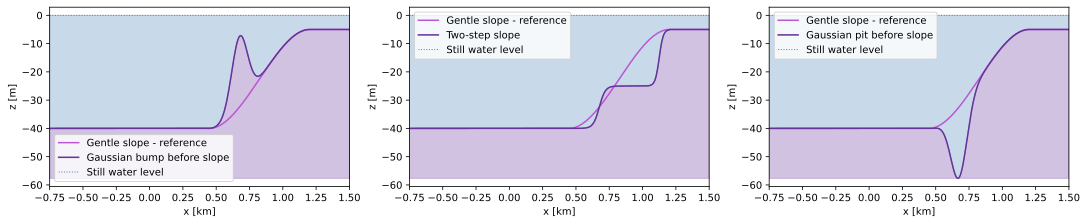

In [44]:
#plotter_bathy.plot_bathymetry_maps()
plotter_bathy.plot_bathymetry_sections()

In [45]:
display(Markdown("**Rysunek 1. Rodzaje batymetrii przedstawione w pełnej długości domeny w x.**"))

**Rysunek 1. Rodzaje batymetrii przedstawione w pełnej długości domeny w x.**

## Warunek początkowy – pojedyncza fala nad głębokim dnem

Na głębokiej, płaskiej wodzie zadano pojedynczą falę o kształcie Gaussa $\eta(x) = A \exp\left[-\left(\frac{x - x_0}{\sigma}\right)^2\right]$,  $A = 10 \, \mathrm{m}$, $x_0 = 300 \, \mathrm{m}$ i $\sigma = 75 \, \mathrm{m}$. Początkowa prędkość w kierunku $x$ nadawana jest tylko w obszarze $|x - x_0| \le u_\sigma \sigma$ (z $u_\sigma = 3$) i jest proporcjonalna do lokalnej wysokości fali 
\begin{equation}
u(x)=\begin{cases}
\dfrac{c_0}{H_0}\,\eta(x), & |x - x_0| \le u_\sigma \sigma,\\[4pt]
0, & \text{poza tym obszarem},
\end{cases}
\end{equation}
gdzie $H_0$ jest głębokością na otwartym morzu, a $c_0 = \sqrt{g H_0}$ to odpowiadająca jej prędkość falowa. Prędkość w kierunku y na starcie jest równa 0.

# Wyniki symulacji
1. **Łagodny stok** - Fala stopniowo hamuje na coraz płytszej wodzie. Jej przód zwalnia szybciej niż tył - fala rośnie, wydłuża się i pojawiają się drobne oscylacje za grzbietem. Przepływ pozostaje gładki, bez odbić.
2. **Wybrzuszenie na stoku** - Najsilniejsze zakłócenia spośród analizowanych przypadków. Fala uderza w wypukłość, gwałtownie hamuje i mocno się spiętrza. Za garbem woda nagle przyspiesza i opada, co deformuje kształt fali i wywołuje lokalne odbicie energii. Powierzchnia staje się wyraźnie nieregularna.
3. **Dwustopniowy stok** - Dwa progi głębokości powodują dwie fazy hamowania i dwa wyraźne spiętrzenia. W rezultacie fala ma najbardziej „warstwowy”, wielofazowy kształt, a zaburzenia nakładają się na siebie.
4. **Wgłębienie na stoku** - Woda lokalnie pogłębia się, fala przyspiesza i rozciąga. Po wyjściu z dołka napotyka ponownie płyciznę, gwałtownie hamuje i spiętrza się, co prowadzi do zderzenia szybszego fragmentu fali z wolniejszym. Pojawiają się zaburzenia powierzchni oraz słabe odbicia.


In [27]:
#plotter.animate_surfaces_3d(zlim=(-60, 30));
plot_frame = plotter.make_surface_anim_plotter(zlim=(-60, 20))

In [33]:
#fig = plot_frame(40)
#fig.savefig("grafiki/3D_wave_frame_40.pdf", dpi=300)
#pyplot.show()

In [46]:
#plotter.animate_sections_1d(zlim=(-60, 30));
plot_frame = plotter.make_sections_anim_plotter(zlim=(-60, 20))

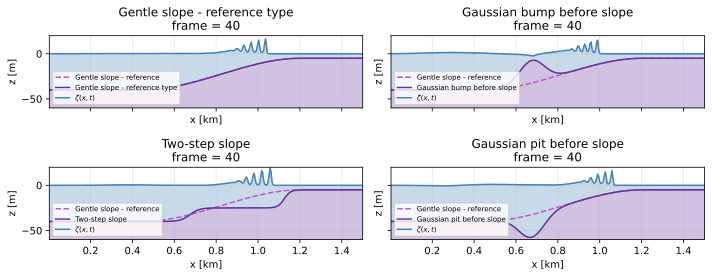

In [47]:
fig = plot_frame(40)
fig.savefig("grafiki/sections_frame_40.pdf", dpi=300)
pyplot.show()

In [48]:
display(Markdown("**Rysunek 2. Klatka z animacji w przekroju.**"))

**Rysunek 2. Klatka z animacji w przekroju.**

In [53]:
#plotter.animate_velocity_field(stride=8);
plot_frame = plotter.make_velocity_anim_plotter(stride=10)

In [54]:
fig = plot_frame(40)
fig.savefig("grafiki/velocity_frame_40.pdf", dpi=300)
pyplot.show()

In [55]:
display(Markdown("**Rysunek 3.Pole prędkości.**"))

**Rysunek 3.Pole prędkości.**

## Czas dotarcia fali do brzegu – zależność od batymetrii

Dla wszystkich batymetrii czas dotarcia fali na środek płycizny (uznanej za brzeg) mieści się w przedziale ok. **49–57 s**. Wybrzuszenie silnie hamuje przepływ, wgłębienie najpierw przyspiesza, potem spowalnia, a stok dwustopniowy pozwala fali wejść na płyciznę najszybciej. Kolejność dotarcia fal dla badanych batymetrii pozostaje identyczna niezależnie od zmiany rozdzielczości - co za tym idzie odzwierciedla fizykę. Na poniższych wykresach pokazano wysokość fali na brzegu w czasie dla każdej z badanych rozdzielczości z zaznaczeniem momentu dojścia fali do brzegu. Na drugim wykresie przedstawiono maksymalną wysokość fali w czasie, aż do jej dotarcia do brzegu.

In [24]:
#exp.print_arrival_summary()

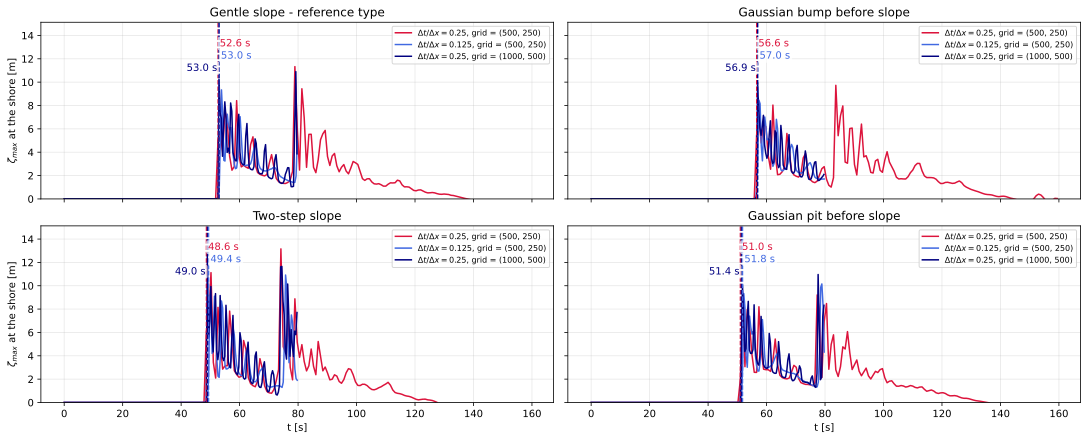

**Rysunek 4. Czasy dotarcia fali do brzegu dla różnych batymetrii i rozdzielczości siatek i czasu.**

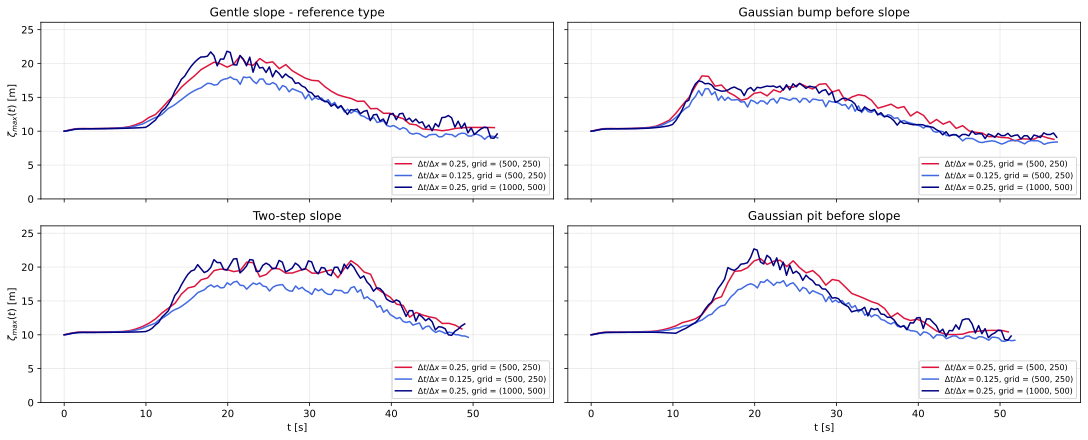

**Rysunek 5. Maksymalne wysokości fali od momentu początku propagacji do dotarcia do brzegu dla różnych batymetrii i rozdzielczości siatek i czasu.**

In [56]:
plotter.plot_wave_heights_at_shore([exp, exp_test_dt, exp_test_dxdy], labels=labels);
display(Markdown("**Rysunek 4. Czasy dotarcia fali do brzegu dla różnych batymetrii i rozdzielczości siatek i czasu.**"))
plotter.plot_max_zeta_series_midline([exp, exp_test_dt, exp_test_dxdy], labels=labels);
display(Markdown("**Rysunek 5. Maksymalne wysokości fali od momentu początku propagacji do dotarcia do brzegu dla różnych batymetrii i rozdzielczości siatek i czasu.**"))

### Wpływ rozdzielczości czasowej i przestrzennej

Porównano dwie wartości $\Delta t/\Delta x$ przy **tej samej siatce ($500 \times 250$)** (rysunek 4.). Zmiana z $\Delta t/\Delta$ $x = 0.25$ na **0.125** powoduje przesunięcie czasu dotarcia o zaledwie **0.4–0.8 s**. Dla wszystkich batymetrii czasy z mniejszym krokiem czasowym są minimalnie **większe** – fala dociera odrobinę później. Następnie porównano siatkę **$500 \times 250$** z **$1000 \times 500$** przy tym samym stosunku $\Delta t/\Delta$ $x = 0.25$ (rysunek 4.). Czasy dotarcia różnią się znów o **maksymalnie ~0.4–0.8 s**. Oznacza to, że rozdzielczości przestrzenna i czasowa mają niewielki wpływ na globalny czas dotarcia. Przebiegi $\zeta_{\max}(t)$ (rysunek 5.) mają bardzo podobny kształt, jednak dużo dokładniejsze i szczegółowe odwzorowanie propagacji fali uzyskiwane jest dla lepszych rozdzielczości (zwiększonych).